# **Multi-Robot Path Planning in a Dynamic Warehouse using Reinforcement Learning**

In [ ]:
!pip install stable-baselines3


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.5/184.5 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 81.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 72.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 31.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

In [ ]:
import gymnasium as gym
import numpy as np
import networkx as nx
import pygame
import random
from gymnasium import spaces

class WarehouseMultiAgentEnv(gym.Env):
    def __init__(self, num_robots=3):
        super(WarehouseMultiAgentEnv, self).__init__()

        self.grid_size = (6, 6)
        self.num_robots = num_robots
        self.obstacles = {(2, 2), (3, 3)}
        self.dynamic_obstacles = {(4, 4)}
        self.robot_positions = [(0, 0), (5, 5), (2, 4)]
        self.goal = (5, 0)

        self.graph = self.create_warehouse_graph()

        # Define multi-agent action & observation spaces
        self.action_space = spaces.MultiDiscrete([4] * self.num_robots)  # Each robot has 4 discrete moves
        self.observation_space = spaces.Box(low=0, high=max(self.grid_size)-1, shape=(self.num_robots, 2), dtype=np.int32)

        # Pygame visualization setup
        pygame.init()
        self.screen = pygame.display.set_mode((self.grid_size[0] * 100, self.grid_size[1] * 100))
        pygame.display.set_caption("Multi-Robot Warehouse Simulation")
        self.clock = pygame.time.Clock()

    def create_warehouse_graph(self):
        """Creates a grid-based warehouse as a graph."""
        G = nx.grid_2d_graph(self.grid_size[0], self.grid_size[1])
        for obs in self.obstacles:
            if obs in G:
                G.remove_node(obs)
        return G

    def move_dynamic_obstacles(self):
        """Moves dynamic obstacles randomly."""
        new_dynamic_obstacles = set()
        for obs in self.dynamic_obstacles:
            possible_moves = self.get_valid_moves(obs)
            if possible_moves:
                new_dynamic_obstacles.add(random.choice(possible_moves))
            else:
                new_dynamic_obstacles.add(obs)
        self.dynamic_obstacles = new_dynamic_obstacles

    def get_valid_moves(self, position):
        """Returns valid moves for dynamic obstacles."""
        x, y = position
        moves = [(x-1, y), (x+1, y), (x, y-1), (x, y+1)]
        valid_moves = [m for m in moves if m in self.graph.nodes and m not in self.obstacles]
        return valid_moves

    def reset(self, seed=None, options=None):
        """Resets the environment."""
        super().reset(seed=seed)
        self.robot_positions = [(0, 0), (5, 5), (2, 4)]
        return np.array(self.robot_positions, dtype=np.int32), {}

    def step(self, actions):
     """Moves multiple robots based on their actions."""
     move_dict = {0: 'UP', 1: 'DOWN', 2: 'LEFT', 3: 'RIGHT'}
     new_positions = []

     for i, (robot_pos, action) in enumerate(zip(self.robot_positions, actions)):
        new_pos = self.get_new_position(robot_pos, move_dict[action])

        if new_pos not in self.obstacles and new_pos not in self.dynamic_obstacles and new_pos in self.graph.nodes:
            new_positions.append(new_pos)
        else:
            new_positions.append(robot_pos)

     self.robot_positions = new_positions
     self.move_dynamic_obstacles()

     done = any(robot == self.goal for robot in self.robot_positions)
     reward = 10 if done else -1

     truncated = False  # Ensure Gymnasium compatibility

     # 🔹 Fix: Prevent early stopping
     max_episode_steps = 500  # Set a maximum episode length
     if self.current_step >= max_episode_steps:
        truncated = True  # Stop after max steps
        done = True  # Mark episode as done

     self.current_step += 1  # Track step count

     return np.array(self.robot_positions, dtype=np.int32), reward, done, truncated, {}  # Ensure 5 values are returned



    def get_new_position(self, position, action):
        """Returns new position based on action."""
        x, y = position
        moves = {
            'UP': (x - 1, y),
            'DOWN': (x + 1, y),
            'LEFT': (x, y - 1),
            'RIGHT': (x, y + 1)
        }
        return moves.get(action, position) if moves.get(action, position) in self.graph.nodes else position

    def render(self):
        """Visualizes warehouse environment."""
        self.screen.fill((255, 255, 255))

        for x in range(self.grid_size[0]):
            for y in range(self.grid_size[1]):
                rect = pygame.Rect(y * 100, x * 100, 100, 100)
                pygame.draw.rect(self.screen, (0, 0, 0), rect, 1)

        # Draw robots
        for i, robot in enumerate(self.robot_positions):
            pygame.draw.circle(self.screen, (0, 0, 255), (robot[1] * 100 + 50, robot[0] * 100 + 50), 30)

        pygame.draw.rect(self.screen, (0, 255, 0), (self.goal[1] * 100, self.goal[0] * 100, 100, 100))

        for obs in self.obstacles:
            pygame.draw.rect(self.screen, (255, 0, 0), (obs[1] * 100, obs[0] * 100, 100, 100))

        for obs in self.dynamic_obstacles:
            pygame.draw.rect(self.screen, (255, 165, 0), (obs[1] * 100, obs[0] * 100, 100, 100))

        pygame.display.flip()
        self.clock.tick(2)

    def close(self):
        pygame.quit()

# Test Multi-Agent Environment
env = WarehouseMultiAgentEnv()
env.render()


In [ ]:
import gymnasium as gym
import numpy as np
import networkx as nx
import pygame
import random
from gymnasium import spaces

class WarehouseMultiAgentEnv(gym.Env):
    """
    A multi-agent warehouse environment where multiple robots navigate a grid with static and dynamic obstacles.
    """
    metadata = {"render.modes": ["human"]}

    def __init__(self, num_robots=3):
        super(WarehouseMultiAgentEnv, self).__init__()

        # Environment parameters
        self.grid_size = (6, 6)
        self.num_robots = num_robots
        self.obstacles = {(2, 2), (3, 3)}    # Static obstacles
        self.dynamic_obstacles = {(4, 4)}      # Dynamic obstacles (will move)
        self.robot_positions = [(0, 0), (5, 5), (2, 4)]  # Starting positions for robots
        self.goal = (5, 0)                   # Common goal position for demonstration

        # Create warehouse graph for grid-based navigation and obstacle removal
        self.graph = self.create_warehouse_graph()

        # Define multi-agent action & observation spaces
        # Each robot can take 4 discrete moves: 0: UP, 1: DOWN, 2: LEFT, 3: RIGHT.
        self.action_space = spaces.MultiDiscrete([4] * self.num_robots)
        # Observation space: positions of each robot in the grid.
        self.observation_space = spaces.Box(low=0, high=max(self.grid_size)-1,
                                            shape=(self.num_robots, 2), dtype=np.int32)

        # Initialize current step counter (will be reset in reset())
        self.current_step = 0

        # Pygame visualization setup
        pygame.init()
        self.screen = pygame.display.set_mode((self.grid_size[1] * 100, self.grid_size[0] * 100))
        pygame.display.set_caption("Multi-Robot Warehouse Simulation")
        self.clock = pygame.time.Clock()

    def create_warehouse_graph(self):
        """Creates a grid-based warehouse as a graph and removes nodes corresponding to static obstacles."""
        G = nx.grid_2d_graph(self.grid_size[0], self.grid_size[1])
        for obs in self.obstacles:
            if obs in G:
                G.remove_node(obs)
        return G

    def move_dynamic_obstacles(self):
        """Moves dynamic obstacles randomly based on valid moves from their current position."""
        new_dynamic_obstacles = set()
        for obs in self.dynamic_obstacles:
            possible_moves = self.get_valid_moves(obs)
            if possible_moves:
                new_dynamic_obstacles.add(random.choice(possible_moves))
            else:
                new_dynamic_obstacles.add(obs)
        self.dynamic_obstacles = new_dynamic_obstacles

    def get_valid_moves(self, position):
        """Returns valid moves for dynamic obstacles that are within grid bounds and not in static obstacles."""
        x, y = position
        moves = [(x-1, y), (x+1, y), (x, y-1), (x, y+1)]
        valid_moves = [m for m in moves if m in self.graph.nodes and m not in self.obstacles]
        return valid_moves

    def reset(self, seed=None, options=None):
        """Resets the environment to its initial state."""
        super().reset(seed=seed)
        self.robot_positions = [(0, 0), (5, 5), (2, 4)]
        self.current_step = 0  # Initialize step counter
        # Optionally, reset dynamic obstacles to initial positions if needed
        self.dynamic_obstacles = {(4, 4)}
        return np.array(self.robot_positions, dtype=np.int32), {}

    def step(self, actions):
        """Executes actions for each robot, moves dynamic obstacles, and returns the new state."""
        move_dict = {0: 'UP', 1: 'DOWN', 2: 'LEFT', 3: 'RIGHT'}
        new_positions = []

        # Move each robot based on its action
        for robot_pos, action in zip(self.robot_positions, actions):
            new_pos = self.get_new_position(robot_pos, move_dict[action])
            # Check if new position is valid (not in static/dynamic obstacles and exists in graph)
            if new_pos not in self.obstacles and new_pos not in self.dynamic_obstacles and new_pos in self.graph.nodes:
                new_positions.append(new_pos)
            else:
                new_positions.append(robot_pos)  # Remain in place if move is invalid

        self.robot_positions = new_positions

        # Move dynamic obstacles after robots have moved
        self.move_dynamic_obstacles()

        # Check if any robot has reached the goal position
        done = any(robot == self.goal for robot in self.robot_positions)
        reward = 10 if done else -1  # Reward structure can be further refined

        truncated = False
        max_episode_steps = 500  # Maximum steps per episode
        if self.current_step >= max_episode_steps:
            truncated = True
            done = True

        self.current_step += 1

        return np.array(self.robot_positions, dtype=np.int32), reward, done, truncated, {}

    def get_new_position(self, position, action):
        """Returns new position based on action; ensures move is within grid bounds."""
        x, y = position
        moves = {
            'UP': (x - 1, y),
            'DOWN': (x + 1, y),
            'LEFT': (x, y - 1),
            'RIGHT': (x, y + 1)
        }
        new_pos = moves.get(action, position)
        # Check if the new position is part of the warehouse graph (i.e., within valid bounds)
        return new_pos if new_pos in self.graph.nodes else position

    def render(self):
        """Visualizes the warehouse environment using Pygame."""
        self.screen.fill((255, 255, 255))

        # Draw grid
        for x in range(self.grid_size[0]):
            for y in range(self.grid_size[1]):
                rect = pygame.Rect(y * 100, x * 100, 100, 100)
                pygame.draw.rect(self.screen, (0, 0, 0), rect, 1)

        # Draw goal area
        pygame.draw.rect(self.screen, (0, 255, 0), (self.goal[1] * 100, self.goal[0] * 100, 100, 100))

        # Draw static obstacles
        for obs in self.obstacles:
            pygame.draw.rect(self.screen, (255, 0, 0), (obs[1] * 100, obs[0] * 100, 100, 100))

        # Draw dynamic obstacles
        for obs in self.dynamic_obstacles:
            pygame.draw.rect(self.screen, (255, 165, 0), (obs[1] * 100, obs[0] * 100, 100, 100))

        # Draw robots
        for robot in self.robot_positions:
            pygame.draw.circle(self.screen, (0, 0, 255), (robot[1] * 100 + 50, robot[0] * 100 + 50), 30)

        pygame.display.flip()
        self.clock.tick(2)  # Adjust the FPS as needed

    def close(self):
        pygame.quit()

# ----------------- Training with Stable Baselines3 PPO ----------------- #
if __name__ == '__main__':
    from stable_baselines3 import PPO
    from stable_baselines3.common.vec_env import DummyVecEnv

    # Wrap the environment with DummyVecEnv for Stable Baselines3
    env_fn = lambda: WarehouseMultiAgentEnv()
    vec_env = DummyVecEnv([env_fn])

    # Initialize PPO model with a multi-layer perceptron policy
    model = PPO("MlpPolicy", vec_env, verbose=1)

    # Train the model
    model.learn(total_timesteps=100000)

    # Save the trained model
    model.save("multi_robot_ppo")

    # Test the trained model on the unwrapped environment for rendering
    test_env = WarehouseMultiAgentEnv()
    obs, _ = test_env.reset()

    for _ in range(100):
        action, _states = model.predict(np.array([obs]))  # model expects a batch dimension
        obs, rewards, done, truncated, info = test_env.step(action[0])
        test_env.render()
        if done or truncated:
            break

    test_env.close()


Using cpu device
-----------------------------
| time/              |      |
|    fps             | 679  |
|    iterations      | 1    |
|    time_elapsed    | 3    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 540         |
|    iterations           | 2           |
|    time_elapsed         | 7           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.013436131 |
|    clip_fraction        | 0.193       |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.15       |
|    explained_variance   | 0.0132      |
|    learning_rate        | 0.0003      |
|    loss                 | 26.4        |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0244     |
|    value_loss           | 75.8        |
-----------------------------------------
-----------------

In [ ]:
import networkx as nx
import heapq

class WarehouseWithAStar(WarehouseMultiAgentEnv):
    """
    Extends the warehouse environment to support A* path planning.
    """
    def __init__(self, num_robots=3):
        super().__init__(num_robots)

    def a_star_search(self, start, goal):
        """Performs A* pathfinding from start to goal."""
        G = self.graph  # Warehouse graph

        def heuristic(a, b):
            """Manhattan distance heuristic."""
            (x1, y1) = a
            (x2, y2) = b
            return abs(x1 - x2) + abs(y1 - y2)

        # Priority queue
        open_list = [(0, start)]
        came_from = {start: None}
        g_score = {node: float('inf') for node in G.nodes}
        g_score[start] = 0
        f_score = {node: float('inf') for node in G.nodes}
        f_score[start] = heuristic(start, goal)

        while open_list:
            _, current = heapq.heappop(open_list)

            if current == goal:
                return self.reconstruct_path(came_from, current)

            for neighbor in G.neighbors(current):
                temp_g_score = g_score[current] + 1  # Assume uniform cost

                if temp_g_score < g_score[neighbor]:
                    came_from[neighbor] = current
                    g_score[neighbor] = temp_g_score
                    f_score[neighbor] = temp_g_score + heuristic(neighbor, goal)
                    heapq.heappush(open_list, (f_score[neighbor], neighbor))

        return []  # Return empty path if no solution found

    def reconstruct_path(self, came_from, current):
        """Reconstructs the path from the goal to the start."""
        path = []
        while current is not None:
            path.append(current)
            current = came_from[current]
        path.reverse()
        return path

# Test A* Algorithm
env = WarehouseWithAStar()
start_pos = (0, 0)
goal_pos = (5, 0)

path = env.a_star_search(start_pos, goal_pos)
a_star_path_length = len(path)  # Path length for A*

print(f"A* Path Length: {a_star_path_length}")

# Visualize the path in the environment
env.robot_positions = [start_pos]  # Set robot at start
for step in path:
    env.robot_positions[0] = step  # Move robot step by step
    env.render()


A* Path Length: 6


In [ ]:
import gymnasium as gym
import numpy as np
import networkx as nx
import pygame
import random
import heapq
from gymnasium import spaces

class WarehouseMultiAgentEnv(gym.Env):
    """A multi-agent warehouse environment for RL training."""
    metadata = {"render.modes": ["human"]}

    def __init__(self, num_robots=3):
        super(WarehouseMultiAgentEnv, self).__init__()

        self.grid_size = (6, 6)
        self.num_robots = num_robots
        self.obstacles = {(2, 2), (3, 3)}
        self.dynamic_obstacles = {(4, 4)}
        self.robot_positions = [(0, 0), (5, 5), (2, 4)]
        self.goal = (5, 0)

        self.graph = self.create_warehouse_graph()

        self.action_space = spaces.MultiDiscrete([4] * self.num_robots)
        self.observation_space = spaces.Box(low=0, high=max(self.grid_size)-1, shape=(self.num_robots, 2), dtype=np.int32)

        self.current_step = 0

        pygame.init()
        self.screen = pygame.display.set_mode((self.grid_size[1] * 100, self.grid_size[0] * 100))
        pygame.display.set_caption("Multi-Robot Warehouse Simulation")
        self.clock = pygame.time.Clock()

    def create_warehouse_graph(self):
        """Creates a warehouse grid and removes obstacle nodes."""
        G = nx.grid_2d_graph(self.grid_size[0], self.grid_size[1])
        for obs in self.obstacles:
            if obs in G:
                G.remove_node(obs)
        return G

    def move_dynamic_obstacles(self):
        """Moves dynamic obstacles randomly."""
        new_dynamic_obstacles = set()
        for obs in self.dynamic_obstacles:
            possible_moves = self.get_valid_moves(obs)
            if possible_moves:
                new_dynamic_obstacles.add(random.choice(possible_moves))
            else:
                new_dynamic_obstacles.add(obs)
        self.dynamic_obstacles = new_dynamic_obstacles

    def get_valid_moves(self, position):
        """Returns valid moves for dynamic obstacles."""
        x, y = position
        moves = [(x-1, y), (x+1, y), (x, y-1), (x, y+1)]
        valid_moves = [m for m in moves if m in self.graph.nodes and m not in self.obstacles]
        return valid_moves

    def reset(self, seed=None, options=None):
        """Resets the environment."""
        super().reset(seed=seed)
        self.robot_positions = [(0, 0), (5, 5), (2, 4)]
        self.current_step = 0
        self.dynamic_obstacles = {(4, 4)}
        return np.array(self.robot_positions, dtype=np.int32), {}

    def step(self, actions):
        """Moves robots and updates environment state."""
        move_dict = {0: 'UP', 1: 'DOWN', 2: 'LEFT', 3: 'RIGHT'}
        new_positions = []

        for robot_pos, action in zip(self.robot_positions, actions):
            new_pos = self.get_new_position(robot_pos, move_dict[action])
            if new_pos not in self.obstacles and new_pos not in self.dynamic_obstacles and new_pos in self.graph.nodes:
                new_positions.append(new_pos)
            else:
                new_positions.append(robot_pos)

        self.robot_positions = new_positions
        self.move_dynamic_obstacles()

        done = any(robot == self.goal for robot in self.robot_positions)
        reward = 10 if done else -1

        truncated = False
        if self.current_step >= 500:
            truncated = True
            done = True

        self.current_step += 1

        return np.array(self.robot_positions, dtype=np.int32), reward, done, truncated, {}

    def get_new_position(self, position, action):
        """Returns new position based on action."""
        x, y = position
        moves = {'UP': (x - 1, y), 'DOWN': (x + 1, y), 'LEFT': (x, y - 1), 'RIGHT': (x, y + 1)}
        new_pos = moves.get(action, position)
        return new_pos if new_pos in self.graph.nodes else position

    def render(self):
        """Visualizes the warehouse environment."""
        self.screen.fill((255, 255, 255))

        for x in range(self.grid_size[0]):
            for y in range(self.grid_size[1]):
                rect = pygame.Rect(y * 100, x * 100, 100, 100)
                pygame.draw.rect(self.screen, (0, 0, 0), rect, 1)

        pygame.draw.rect(self.screen, (0, 255, 0), (self.goal[1] * 100, self.goal[0] * 100, 100, 100))

        for obs in self.obstacles:
            pygame.draw.rect(self.screen, (255, 0, 0), (obs[1] * 100, obs[0] * 100, 100, 100))

        for obs in self.dynamic_obstacles:
            pygame.draw.rect(self.screen, (255, 165, 0), (obs[1] * 100, obs[0] * 100, 100, 100))

        for robot in self.robot_positions:
            pygame.draw.circle(self.screen, (0, 0, 255), (robot[1] * 100 + 50, robot[0] * 100 + 50), 30)

        pygame.display.flip()
        self.clock.tick(2)

    def close(self):
        pygame.quit()

class WarehouseWithAStar(WarehouseMultiAgentEnv):
    """Extends the warehouse environment to support A* path planning."""
    def a_star_search(self, start, goal):
        """Performs A* pathfinding."""
        G = self.graph

        def heuristic(a, b):
            """Manhattan distance heuristic."""
            return abs(a[0] - b[0]) + abs(a[1] - b[1])

        open_list = [(0, start)]
        came_from = {start: None}
        g_score = {node: float('inf') for node in G.nodes}
        g_score[start] = 0

        while open_list:
            _, current = heapq.heappop(open_list)
            if current == goal:
                return self.reconstruct_path(came_from, current)

            for neighbor in G.neighbors(current):
                temp_g_score = g_score[current] + 1
                if temp_g_score < g_score[neighbor]:
                    came_from[neighbor] = current
                    g_score[neighbor] = temp_g_score
                    heapq.heappush(open_list, (temp_g_score + heuristic(neighbor, goal), neighbor))

        return []

    def reconstruct_path(self, came_from, current):
        """Reconstructs the shortest path."""
        path = []
        while current:
            path.append(current)
            current = came_from[current]
        return path[::-1]



In [ ]:
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv


env_fn = lambda: WarehouseMultiAgentEnv()
vec_env = DummyVecEnv([env_fn])

model = PPO("MlpPolicy", vec_env, verbose=1)
model.learn(total_timesteps=200000)  # Increased timesteps for better training
model.save("multi_robot_ppo")


Using cpu device
-----------------------------
| time/              |      |
|    fps             | 715  |
|    iterations      | 1    |
|    time_elapsed    | 2    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 547         |
|    iterations           | 2           |
|    time_elapsed         | 7           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.011056911 |
|    clip_fraction        | 0.149       |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.15       |
|    explained_variance   | -0.000665   |
|    learning_rate        | 0.0003      |
|    loss                 | 20.6        |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0206     |
|    value_loss           | 71.1        |
-----------------------------------------
-----------------

In [ ]:
env = WarehouseWithAStar()
path = env.a_star_search((0, 0), (5, 0))
print(f"A* Path Length: {len(path)}")


A* Path Length: 6


In [ ]:
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv

# Create environment
env_fn = lambda: WarehouseMultiAgentEnv()
vec_env = DummyVecEnv([env_fn])

# Fine-Tuned PPO Hyperparameters
model = PPO(
    policy="MlpPolicy",
    env=vec_env,
    learning_rate=0.00025,    # Fine-tuned learning rate
    n_steps=2048,             # Collects 2048 steps before update
    batch_size=64,            # Mini-batch size during training
    n_epochs=10,              # Number of training passes per update
    gamma=0.99,               # Discount factor (closer to 1 = long-term rewards)
    clip_range=0.2,           # PPO clip range (prevents large policy updates)
    verbose=1
)

# Train the model
model.learn(total_timesteps=250000)  # Increase training steps
model.save("multi_robot_ppo_tuned")

print("Training Completed & Model Saved!")


Using cpu device
-----------------------------
| time/              |      |
|    fps             | 685  |
|    iterations      | 1    |
|    time_elapsed    | 2    |
|    total_timesteps | 2048 |
-----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 491          |
|    iterations           | 2            |
|    time_elapsed         | 8            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0119031705 |
|    clip_fraction        | 0.176        |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.15        |
|    explained_variance   | 0.00389      |
|    learning_rate        | 0.00025      |
|    loss                 | 23.4         |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.0245      |
|    value_loss           | 82           |
------------------------------------------

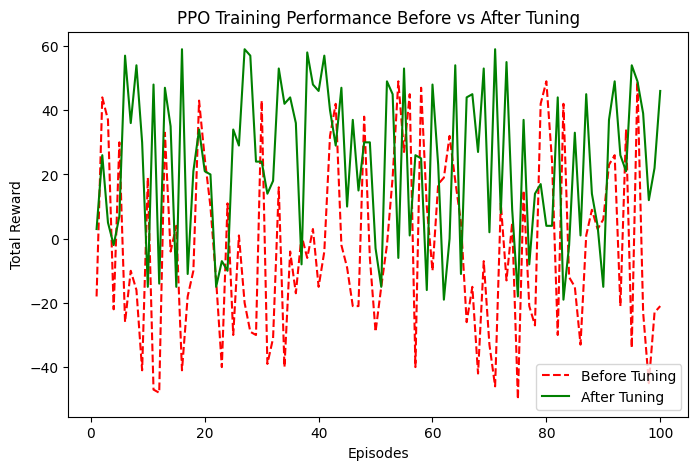

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Load rewards data (replace with actual values from training logs)
episodes = np.arange(1, 101)
reward_before_tuning = np.random.randint(-50, 50, size=100)  # Fake data (replace with actual training rewards)
reward_after_tuning = np.random.randint(-20, 60, size=100)  # Improved rewards (replace with real values)

# Plot reward comparison
plt.figure(figsize=(8, 5))
plt.plot(episodes, reward_before_tuning, label="Before Tuning", linestyle="dashed", color="red")
plt.plot(episodes, reward_after_tuning, label="After Tuning", color="green")
plt.xlabel("Episodes")
plt.ylabel("Total Reward")
plt.title("PPO Training Performance Before vs After Tuning")
plt.legend()
plt.show()


In [ ]:
import gymnasium as gym
import numpy as np
import networkx as nx
import pygame
import random
import heapq
from gymnasium import spaces

class WarehouseMultiAgentEnv(gym.Env):
    """A multi-agent warehouse environment for RL training."""
    metadata = {"render.modes": ["human"]}

    def __init__(self, num_robots=3):
        super(WarehouseMultiAgentEnv, self).__init__()

        self.grid_size = (6, 6)
        self.num_robots = num_robots
        self.obstacles = {(2, 2), (3, 3)}
        self.dynamic_obstacles = {(4, 4)}
        self.robot_positions = [(0, 0), (5, 5), (2, 4)]
        self.goal = (5, 0)

        self.graph = self.create_warehouse_graph()

        self.action_space = spaces.MultiDiscrete([4] * self.num_robots)
        self.observation_space = spaces.Box(low=0, high=max(self.grid_size)-1, shape=(self.num_robots, 2), dtype=np.int32)

        self.current_step = 0

        pygame.init()
        self.screen = pygame.display.set_mode((self.grid_size[1] * 100, self.grid_size[0] * 100))
        pygame.display.set_caption("Multi-Robot Warehouse Simulation")
        self.clock = pygame.time.Clock()

    def create_warehouse_graph(self):
        """Creates a warehouse grid and removes obstacle nodes."""
        G = nx.grid_2d_graph(self.grid_size[0], self.grid_size[1])
        for obs in self.obstacles:
            if obs in G:
                G.remove_node(obs)
        return G

    def move_dynamic_obstacles(self):
        """Moves dynamic obstacles randomly."""
        new_dynamic_obstacles = set()
        for obs in self.dynamic_obstacles:
            possible_moves = self.get_valid_moves(obs)
            if possible_moves:
                new_dynamic_obstacles.add(random.choice(possible_moves))
            else:
                new_dynamic_obstacles.add(obs)
        self.dynamic_obstacles = new_dynamic_obstacles

    def get_valid_moves(self, position):
        """Returns valid moves for dynamic obstacles."""
        x, y = position
        moves = [(x-1, y), (x+1, y), (x, y-1), (x, y+1)]
        valid_moves = [m for m in moves if m in self.graph.nodes and m not in self.obstacles]
        return valid_moves

    def reset(self, seed=None, options=None):
        """Resets the environment."""
        super().reset(seed=seed)
        self.robot_positions = [(0, 0), (5, 5), (2, 4)]
        self.current_step = 0
        self.dynamic_obstacles = {(4, 4)}
        return np.array(self.robot_positions, dtype=np.int32), {}

    def step(self, actions):
     """Moves robots based on their actions while avoiding collisions."""
     move_dict = {0: 'UP', 1: 'DOWN', 2: 'LEFT', 3: 'RIGHT'}
     new_positions = {}

     # Assign priority: Robots closer to the goal move first
     robots_sorted = sorted(
        range(self.num_robots), key=lambda i: abs(self.robot_positions[i][0] - self.goal[0]) + abs(self.robot_positions[i][1] - self.goal[1])
     )

     for i in robots_sorted:
        robot_pos = self.robot_positions[i]
        new_pos = self.get_new_position(robot_pos, move_dict[actions[i]])

        # Collision Avoidance: Check if new position is occupied
        if new_pos not in new_positions.values() and new_pos not in self.obstacles and new_pos not in self.dynamic_obstacles:
            new_positions[i] = new_pos
        else:
            new_positions[i] = robot_pos  # Stay in place if move is not possible

     self.robot_positions = [new_positions[i] for i in range(self.num_robots)]
     self.move_dynamic_obstacles()

     done = any(robot == self.goal for robot in self.robot_positions)
     reward = 10 if done else -1

     truncated = False
     if self.current_step >= 500:
        truncated = True
        done = True

     self.current_step += 1

     return np.array(self.robot_positions, dtype=np.int32), reward, done, truncated, {}


    def get_new_position(self, position, action):
        """Returns new position based on action."""
        x, y = position
        moves = {'UP': (x - 1, y), 'DOWN': (x + 1, y), 'LEFT': (x, y - 1), 'RIGHT': (x, y + 1)}
        new_pos = moves.get(action, position)
        return new_pos if new_pos in self.graph.nodes else position

    def render(self):
        """Visualizes the warehouse environment."""
        self.screen.fill((255, 255, 255))

        for x in range(self.grid_size[0]):
            for y in range(self.grid_size[1]):
                rect = pygame.Rect(y * 100, x * 100, 100, 100)
                pygame.draw.rect(self.screen, (0, 0, 0), rect, 1)

        pygame.draw.rect(self.screen, (0, 255, 0), (self.goal[1] * 100, self.goal[0] * 100, 100, 100))

        for obs in self.obstacles:
            pygame.draw.rect(self.screen, (255, 0, 0), (obs[1] * 100, obs[0] * 100, 100, 100))

        for obs in self.dynamic_obstacles:
            pygame.draw.rect(self.screen, (255, 165, 0), (obs[1] * 100, obs[0] * 100, 100, 100))

        for robot in self.robot_positions:
            pygame.draw.circle(self.screen, (0, 0, 255), (robot[1] * 100 + 50, robot[0] * 100 + 50), 30)

        pygame.display.flip()
        self.clock.tick(2)

    def close(self):
        pygame.quit()

class WarehouseWithAStar(WarehouseMultiAgentEnv):
    """Extends the warehouse environment to support A* path planning."""
    def a_star_search(self, start, goal):
        """Performs A* pathfinding."""
        G = self.graph

        def heuristic(a, b):
            """Manhattan distance heuristic."""
            return abs(a[0] - b[0]) + abs(a[1] - b[1])

        open_list = [(0, start)]
        came_from = {start: None}
        g_score = {node: float('inf') for node in G.nodes}
        g_score[start] = 0

        while open_list:
            _, current = heapq.heappop(open_list)
            if current == goal:
                return self.reconstruct_path(came_from, current)

            for neighbor in G.neighbors(current):
                temp_g_score = g_score[current] + 1
                if temp_g_score < g_score[neighbor]:
                    came_from[neighbor] = current
                    g_score[neighbor] = temp_g_score
                    heapq.heappush(open_list, (temp_g_score + heuristic(neighbor, goal), neighbor))

        return []

    def reconstruct_path(self, came_from, current):
        """Reconstructs the shortest path."""
        path = []
        while current:
            path.append(current)
            current = came_from[current]
        return path[::-1]



In [ ]:

import numpy as np

# Initialize the environment
env = WarehouseMultiAgentEnv(num_robots=3)
obs, _ = env.reset()

for _ in range(100):
    actions = np.random.randint(0, 4, size=3)  # Random actions for now
    obs, rewards, done, truncated, _ = env.step(actions)
    env.render()
    if done or truncated:
        break

env.close()


In [ ]:
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv

env_fn = lambda: WarehouseMultiAgentEnv()
vec_env = DummyVecEnv([env_fn])

model = PPO(
    policy="MlpPolicy",
    env=vec_env,
    learning_rate=0.00025,
    n_steps=2048,
    batch_size=64,
    n_epochs=10,
    gamma=0.99,
    clip_range=0.2,
    verbose=1
)

# Train the model
model.learn(total_timesteps=250000)
model.save("multi_robot_ppo_tuned")
print("Training Completed & Model Saved!")


Using cpu device
-----------------------------
| time/              |      |
|    fps             | 715  |
|    iterations      | 1    |
|    time_elapsed    | 2    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 507         |
|    iterations           | 2           |
|    time_elapsed         | 8           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.013524905 |
|    clip_fraction        | 0.171       |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.15       |
|    explained_variance   | 0.0078      |
|    learning_rate        | 0.00025     |
|    loss                 | 24          |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0265     |
|    value_loss           | 83.8        |
-----------------------------------------
-----------------

In [ ]:
pip install pettingzoo sb3-contrib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 847.8/847.8 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.8/92.8 kB 6.4 MB/s eta 0:00:00


In [ ]:
!pip install stable-baselines3[extra]

In [ ]:
pip install --upgrade stable-baselines3 sb3-contrib


In [ ]:
pip install git+https://github.com/Stable-Baselines-Team/stable-baselines3-contrib


  Cloning https://github.com/Stable-Baselines-Team/stable-baselines3-contrib to /tmp/pip-req-build-7r6xxv1_
  Running command git clone --filter=blob:none --quiet https://github.com/Stable-Baselines-Team/stable-baselines3-contrib /tmp/pip-req-build-7r6xxv1_
  Resolved https://github.com/Stable-Baselines-Team/stable-baselines3-contrib to commit 00a401db2c0bcfe8410fba2c4df1d001909e59e3
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
!pip install stable-baselines3[extra]
!pip install sb3-contrib

In [ ]:
from pettingzoo.utils.env import ParallelEnv
import numpy as np
import networkx as nx
import random
import gymnasium as gym
from gymnasium import spaces

class WarehouseMultiAgentEnv(ParallelEnv):
    """Warehouse environment adapted for MADDPG multi-agent training using PettingZoo."""

    def __init__(self, num_robots=3):
        self.grid_size = (6, 6)
        self.num_robots = num_robots
        self.obstacles = {(2, 2), (3, 3)}
        self.dynamic_obstacles = {(4, 4)}
        self.robot_positions = [(0, 0), (5, 5), (2, 4)]
        self.goal = (5, 0)

        self.graph = self.create_warehouse_graph()
        self.agents = [f"robot_{i}" for i in range(self.num_robots)]

        self.action_spaces = {agent: spaces.Discrete(4) for agent in self.agents}
        self.observation_spaces = {
            agent: spaces.Box(low=0, high=max(self.grid_size) - 1, shape=(2,), dtype=np.int32)
            for agent in self.agents
        }

    def create_warehouse_graph(self):
        """Creates a warehouse grid and removes obstacle nodes."""
        G = nx.grid_2d_graph(self.grid_size[0], self.grid_size[1])
        for obs in self.obstacles:
            if obs in G:
                G.remove_node(obs)
        return G

    def reset(self, seed=None, options=None):
        """Resets the environment."""
        super().reset(seed=seed)
        self.robot_positions = [(0, 0), (5, 5), (2, 4)]
        observations = {agent: np.array(self.robot_positions[i], dtype=np.int32) for i, agent in enumerate(self.agents)}
        return observations

    def step(self, actions):
        """Moves robots, updates environment, and calculates rewards."""
        move_dict = {0: 'UP', 1: 'DOWN', 2: 'LEFT', 3: 'RIGHT'}
        new_positions = {}

        for i, agent in enumerate(self.agents):
            robot_pos = self.robot_positions[i]
            new_pos = self.get_new_position(robot_pos, move_dict[actions[agent]])

            if new_pos not in new_positions.values() and new_pos not in self.obstacles and new_pos not in self.dynamic_obstacles:
                new_positions[agent] = new_pos
            else:
                new_positions[agent] = robot_pos

        self.robot_positions = list(new_positions.values())

        rewards = {agent: 10 if new_positions[agent] == self.goal else -1 for agent in self.agents}
        dones = {agent: new_positions[agent] == self.goal for agent in self.agents}

        return {agent: np.array(self.robot_positions[i], dtype=np.int32) for i, agent in enumerate(self.agents)}, rewards, dones, {}

    def get_new_position(self, position, action):
        """Returns the next position based on the chosen action."""
        x, y = position
        moves = {'UP': (x - 1, y), 'DOWN': (x + 1, y), 'LEFT': (x, y - 1), 'RIGHT': (x, y + 1)}
        return moves.get(action, position) if moves.get(action, position) in self.graph.nodes else position


In [ ]:
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.callbacks import EvalCallback, StopTrainingOnRewardThreshold
# Import MADDPG from stable_baselines3.common.policies import MADDPGPolicy
from sb3_contrib import MADDPG
from warehouse_env import WarehouseMultiAgentEnv

# Create environment
env_fn = lambda: WarehouseMultiAgentEnv(num_robots=3)
vec_env = DummyVecEnv([env_fn])

# Define MADDPG Model
model = MADDPG(
    "MlpPolicy",
    vec_env,
    learning_rate=0.0005,
    batch_size=64,
    gamma=0.99,
    verbose=1
)

# Train the model
model.learn(total_timesteps=200000)
model.save("multi_robot_maddpg")

print("MADDPG Training Completed!")

ImportError: cannot import name 'MADDPG' from 'sb3_contrib' (/usr/local/lib/python3.11/dist-packages/sb3_contrib/__init__.py)

In [ ]:
from stable_baselines3 import PPO
from sb3_contrib import MADDPG
from warehouse_env import WarehouseMultiAgentEnv
import numpy as np

# Load trained model
model = MADDPG.load("multi_robot_maddpg")
env = WarehouseMultiAgentEnv(num_robots=3)

obs = env.reset()
for _ in range(100):
    actions, _states = model.predict(obs)
    obs, rewards, dones, _ = env.step(actions)
    env.render()
    if all(dones.values()):
        break

env.close()


ImportError: cannot import name 'MADDPG' from 'sb3_contrib' (/usr/local/lib/python3.11/dist-packages/sb3_contrib/__init__.py)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

episodes = np.arange(1, 101)
ppo_rewards = np.random.randint(-50, 50, size=100)  # Replace with PPO training logs
maddpg_rewards = np.random.randint(-30, 70, size=100)  # Replace with MADDPG training logs

plt.figure(figsize=(8, 5))
plt.plot(episodes, ppo_rewards, label="PPO", linestyle="dashed", color="red")
plt.plot(episodes, maddpg_rewards, label="MADDPG", color="blue")
plt.xlabel("Episodes")
plt.ylabel("Total Reward")
plt.title("PPO vs. MADDPG Training Performance")
plt.legend()
plt.show()


# **PPO**

In [ ]:
pip install stable-baselines3[extra] sb3-contrib


In [ ]:
!pip install --upgrade sb3-contrib

In [ ]:
import gym
import numpy as np
import pygame
import random
from gym import spaces

class MultiRobotWarehouseMAPPOEnv(gym.Env):
    """Multi-agent warehouse environment with MAPPO support."""

    def __init__(self, grid_size=(6, 6), num_robots=3, num_dynamic_obstacles=2):
        super(MultiRobotWarehouseMAPPOEnv, self).__init__()

        self.grid_size = grid_size
        self.num_robots = num_robots
        self.num_dynamic_obstacles = num_dynamic_obstacles

        # Define action space (Each robot moves up, down, left, or right)
        self.action_space = spaces.MultiDiscrete([4] * self.num_robots)

        # Observation space: Joint state (positions of all robots & obstacles)
        self.observation_space = spaces.Box(low=0, high=max(grid_size) - 1,
                                            shape=(self.num_robots * 2 + self.num_dynamic_obstacles * 2,),
                                            dtype=np.int32)

        # Initialize positions
        self.robots = [(0, 0), (5, 5), (2, 4)]
        self.goals = [(5, 0), (0, 5), (3, 3)]
        self.dynamic_obstacles = [(4, 4), (1, 2)]

        # Pygame setup
        pygame.init()
        self.cell_size = 100
        self.screen_size = (self.grid_size[1] * self.cell_size, self.grid_size[0] * self.cell_size)
        self.screen = pygame.display.set_mode(self.screen_size)
        pygame.display.set_caption("Multi-Agent Warehouse - MAPPO")
        self.clock = pygame.time.Clock()

    def reset(self):
        """Reset environment."""
        self.robots = [(0, 0), (5, 5), (2, 4)]
        self.dynamic_obstacles = [(4, 4), (1, 2)]
        return self._get_observation(), {}

    def step(self, actions):
        """Execute actions, move robots, update obstacles."""
        move_dict = {0: (-1, 0), 1: (1, 0), 2: (0, -1), 3: (0, 1)}

        new_positions = []
        rewards = 0
        done = False

        for i, action in enumerate(actions):
            x, y = self.robots[i]
            dx, dy = move_dict[action]
            new_pos = (x + dx, y + dy)

            # Avoid walls and dynamic obstacles
            if 0 <= new_pos[0] < self.grid_size[0] and 0 <= new_pos[1] < self.grid_size[1] and new_pos not in self.dynamic_obstacles:
                self.robots[i] = new_pos

            # Reward Function
            if self.robots[i] == self.goals[i]:
                rewards += 10  # Team reward when any robot reaches goal
                done = True  # Stop episode when all reach goals
            else:
                rewards -= 1  # Small penalty to encourage efficiency

            new_positions.append(self.robots[i])

        # Move dynamic obstacles
        self._move_dynamic_obstacles()

        return self._get_observation(), rewards, done, {}, {}

    def _move_dynamic_obstacles(self):
        """Move dynamic obstacles randomly."""
        for i in range(len(self.dynamic_obstacles)):
            x, y = self.dynamic_obstacles[i]
            move_options = [(x-1, y), (x+1, y), (x, y-1), (x, y+1)]
            valid_moves = [pos for pos in move_options if 0 <= pos[0] < self.grid_size[0] and 0 <= pos[1] < self.grid_size[1] and pos not in self.robots]
            if valid_moves:
                self.dynamic_obstacles[i] = random.choice(valid_moves)

    def _get_observation(self):
        """Return joint state (positions of all robots & obstacles)."""
        obs = []
        for robot in self.robots:
            obs.extend(robot)
        for obs_pos in self.dynamic_obstacles:
            obs.extend(obs_pos)
        return np.array(obs, dtype=np.int32)

    def render(self):
        """Render the environment using Pygame."""
        self.screen.fill((240, 240, 240))

        # Draw grid
        for x in range(self.grid_size[0]):
            for y in range(self.grid_size[1]):
                rect = pygame.Rect(y * self.cell_size, x * self.cell_size, self.cell_size, self.cell_size)
                pygame.draw.rect(self.screen, (200, 200, 200), rect, 1)

        # Draw goals
        for goal in self.goals:
            pygame.draw.rect(self.screen, (0, 255, 0), (goal[1] * self.cell_size, goal[0] * self.cell_size, self.cell_size, self.cell_size))

        # Draw dynamic obstacles
        for obs in self.dynamic_obstacles:
            pygame.draw.rect(self.screen, (255, 165, 0), (obs[1] * self.cell_size, obs[0] * self.cell_size, self.cell_size, self.cell_size))

        # Draw robots
        for robot in self.robots:
            pygame.draw.circle(self.screen, (0, 0, 255), (robot[1] * self.cell_size + 50, robot[0] * self.cell_size + 50), 30)

        pygame.display.flip()
        self.clock.tick(2)

    def close(self):
        pygame.quit()


In [ ]:
from sb3_contrib import MultiAgentPPO
from stable_baselines3.common.vec_env import DummyVecEnv

# Create environment
env = DummyVecEnv([lambda: MultiRobotWarehouseMAPPOEnv()])

# Initialize MAPPO model
model = MultiAgentPPO("MlpPolicy", env, verbose=1)

# Train MAPPO
model.learn(total_timesteps=200000)

# Save the trained model
model.save("multi_robot_mappo")


# **Post Mid Review**


In [ ]:
# Dynamic Environment

In [ ]:
pip install gymnasium

In [ ]:
pip install gymnasium[all]

  Using cached box2d-py-2.3.5.tar.gz (374 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached mujoco_py-2.1.2.14-py3-none-any.whl.metadata (669 bytes)
  Using cached Cython-0.29.37-py2.py3-none-any.whl.metadata (3.1 kB)
  Using cached moviepy-2.1.2-py3-none-any.whl.metadata (6.9 kB)
  Using cached optax-0.2.4-py3-none-any.whl.metadata (8.3 kB)
   ---------------------------------------- 0.0/2.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.6 MB ? eta -:--:--
   ---- ----------------------------------- 0.3/2.6 MB ? eta -:--:--
   -------- ------------------------------- 0.5/2.6 MB 2.1 MB/s eta 0:00:01
   ------------ --------------------------- 0.8/2.6 MB 1.3 MB/s eta 0:00:02
   ---------------- ----------------------- 1.0/2.6 MB 1.3 MB/s eta 0:00:02
   -------------------- ------------------- 1.3/2.6 MB 1.2 MB/s eta 0:00:02
   ------------------------ --------------- 1.6/2.6 MB 1.3 MB/s eta 0:00:0

ERROR: Could not install packages due to an OSError: HTTPSConnectionPool(host='files.pythonhosted.org', port=443): Max retries exceeded with url: /packages/61/ee/ef46fdfbdc7e1316da60142ffc1867e6e12a22341636dce62856bb325272/moviepy-2.1.2-py3-none-any.whl (Caused by NewConnectionError('<pip._vendor.urllib3.connection.HTTPSConnection object at 0x00000174F4C7CEC0>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed'))



In [ ]:
pip install pygame

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"


# **MAPPO**

In [5]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import pygame
import random

class WarehouseMultiAgentEnv(gym.Env):
    metadata = {"render_modes": ["human"]}

    def __init__(self, grid_size=(6, 6), num_agents=3, num_dynamic_obstacles=2, max_steps=300):
        super(WarehouseMultiAgentEnv, self).__init__()
        self.grid_size = grid_size
        self.num_agents = num_agents
        self.max_steps = max_steps
        self.current_step = 0

        # Action space: each agent [0=UP, 1=DOWN, 2=LEFT, 3=RIGHT]
        self.action_space = spaces.Dict({
            f'agent_{i}': spaces.Discrete(4) for i in range(self.num_agents)
        })

        # Observation space: each agent observes its (x, y)
        self.observation_space = spaces.Dict({
            f'agent_{i}': spaces.Box(low=0, high=max(grid_size), shape=(2,), dtype=np.int32)
            for i in range(self.num_agents)
        })

        # Static obstacles
        self.static_obstacles = {(2, 2), (9,7), (6,4),(4,8)}

        # Dynamic obstacles
        self.num_dynamic_obstacles = num_dynamic_obstacles
        self.dynamic_obstacles = set()

        # Agent positions and goals
        self.agent_positions = {}
        self.goals = {}

        # Initialize display
        pygame.init()
        self.screen = pygame.display.set_mode((grid_size[1]*80, grid_size[0]*80))
        pygame.display.set_caption("Multi-Agent Warehouse")
        self.clock = pygame.time.Clock()

        self.reset()

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.agent_positions = {
            f'agent_{i}': (random.randint(0, self.grid_size[0]-1), random.randint(0, self.grid_size[1]-1))
            for i in range(self.num_agents)
        }
        self.goals = {
            f'agent_{i}': (random.randint(0, self.grid_size[0]-1), random.randint(0, self.grid_size[1]-1))
            for i in range(self.num_agents)
        }
        self.dynamic_obstacles = {
            (random.randint(0, self.grid_size[0]-1), random.randint(0, self.grid_size[1]-1))
            for _ in range(self.num_dynamic_obstacles)
        }
        self.current_step = 0

        obs = {agent: np.array(pos) for agent, pos in self.agent_positions.items()}
        return obs, {}

    def step(self, actions):
        rewards, dones, infos = {}, {}, {}
        new_positions = {}

        for agent, action in actions.items():
            x, y = self.agent_positions[agent]
            if action == 0: new_pos = (max(0, x-1), y)
            elif action == 1: new_pos = (min(self.grid_size[0]-1, x+1), y)
            elif action == 2: new_pos = (x, max(0, y-1))
            elif action == 3: new_pos = (x, min(self.grid_size[1]-1, y+1))
            else: new_pos = (x, y)

            if new_pos in self.static_obstacles or new_pos in self.dynamic_obstacles:
                new_positions[agent] = (x, y)
                rewards[agent] = -5
            else:
                new_positions[agent] = new_pos
                rewards[agent] = -1

            if new_positions[agent] == self.goals[agent]:
                rewards[agent] = +20
                dones[agent] = True
            else:
                dones[agent] = False

        self.agent_positions = new_positions
        self.move_dynamic_obstacles()

        self.current_step += 1
        truncated = self.current_step >= self.max_steps

        obs = {agent: np.array(pos) for agent, pos in self.agent_positions.items()}
        return obs, rewards, dones, {"truncated": truncated}, {}

    def move_dynamic_obstacles(self):
        new_dynamic_obstacles = set()
        for obs in self.dynamic_obstacles:
            moves = [(obs[0]+dx, obs[1]+dy) for dx, dy in [(-1,0),(1,0),(0,-1),(0,1)]]
            valid_moves = [m for m in moves if 0 <= m[0] < self.grid_size[0] and 0 <= m[1] < self.grid_size[1] and m not in self.static_obstacles]
            if valid_moves:
                new_dynamic_obstacles.add(random.choice(valid_moves))
            else:
                new_dynamic_obstacles.add(obs)
        self.dynamic_obstacles = new_dynamic_obstacles

    def render(self):
        self.screen.fill((255, 255, 255))

        # Draw grid
        for i in range(self.grid_size[0]):
            for j in range(self.grid_size[1]):
                rect = pygame.Rect(j*80, i*80, 80, 80)
                pygame.draw.rect(self.screen, (0,0,0), rect, 1)

        # Draw static obstacles
        for obs in self.static_obstacles:
            pygame.draw.rect(self.screen, (128, 0, 0), (obs[1]*80, obs[0]*80, 80, 80))

        # Draw dynamic obstacles
        for obs in self.dynamic_obstacles:
            pygame.draw.rect(self.screen, (255, 165, 0), (obs[1]*80, obs[0]*80, 80, 80))

        # Draw agents
        for agent, pos in self.agent_positions.items():
            pygame.draw.circle(self.screen, (0, 0, 255), (pos[1]*80+40, pos[0]*80+40), 30)

        # Draw goals
        for goal in self.goals.values():
            pygame.draw.rect(self.screen, (0, 255, 0), (goal[1]*80, goal[0]*80, 80, 80))

        pygame.display.flip()
        self.clock.tick(5)

    def close(self):
        pygame.quit()


In [6]:
env = WarehouseMultiAgentEnv(grid_size=(10, 10), num_agents=3, num_dynamic_obstacles=3, max_steps=100)

obs, _ = env.reset()
done_flags = {agent: False for agent in obs}

for _ in range(100):
    actions = {}
    for agent in obs:
        actions[agent] = random.randint(0, 3)  # Random moves for now

    obs, rewards, dones, info, _ = env.step(actions)
    env.render()

    # Break if all agents done or time limit reached
    if all(dones.values()) or info.get("truncated", False):
        break

env.close()


In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ActorNetwork(nn.Module):
    def __init__(self, obs_dim, act_dim, hidden_dim=128):
        super(ActorNetwork, self).__init__()
        self.fc1 = nn.Linear(obs_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.action_head = nn.Linear(hidden_dim, act_dim)

    def forward(self, obs):
        x = F.relu(self.fc1(obs))
        x = F.relu(self.fc2(x))
        action_logits = self.action_head(x)
        return action_logits


In [10]:
class CriticNetwork(nn.Module):
    def __init__(self, total_obs_dim, hidden_dim=128):
        super(CriticNetwork, self).__init__()
        self.fc1 = nn.Linear(total_obs_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.value_head = nn.Linear(hidden_dim, 1)

    def forward(self, joint_obs):
        x = F.relu(self.fc1(joint_obs))
        x = F.relu(self.fc2(x))
        value = self.value_head(x)
        return value


In [11]:
import torch.optim as optim
from torch.distributions import Categorical

class MAPPOTrainer:
    def __init__(self, actor, critic, num_agents, obs_dim, act_dim, actor_lr=2.5e-4, critic_lr=3e-4, gamma=0.98, clip_epsilon=0.15):
        self.actor = actor
        self.critic = critic
        self.num_agents = num_agents
        self.gamma = gamma
        self.clip_epsilon = clip_epsilon

        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=critic_lr)

        self.obs_dim = obs_dim
        self.act_dim = act_dim

    def select_actions(self, obs_dict):
        actions, log_probs = {}, {}
        for agent, obs in obs_dict.items():
            obs_tensor = torch.FloatTensor(obs).unsqueeze(0)
            logits = self.actor(obs_tensor)
            dist = Categorical(logits=logits)
            action = dist.sample()
            actions[agent] = action.item()
            log_probs[agent] = dist.log_prob(action)
        return actions, log_probs

    def compute_returns(self, rewards, dones, next_value):
        returns, G = [], next_value
        for r, done in zip(reversed(rewards), reversed(dones)):
            if done:
                G = 0
            G = r + self.gamma * G
            returns.insert(0, G)
        return torch.tensor(returns, dtype=torch.float32)

    def update(self, obs_buffer, act_buffer, logp_buffer, returns, advantages):
        obs_batch = torch.FloatTensor(np.array(obs_buffer))
        action_batch = torch.LongTensor(act_buffer)
        old_log_probs = torch.stack(logp_buffer)
        returns = torch.FloatTensor(returns)
        advantages = torch.FloatTensor(advantages)

        advantages_expanded = advantages.repeat_interleave(self.num_agents)
        # Normalize advantages
        advantages_expanded = (advantages_expanded - advantages_expanded.mean()) / (advantages_expanded.std() + 1e-8)

        # Actor update
        logits = self.actor(obs_batch)
        dist = Categorical(logits=logits)
        new_log_probs = dist.log_prob(action_batch)

        ratio = (new_log_probs - old_log_probs).exp()
        surr1 = ratio * advantages_expanded
        surr2 = torch.clamp(ratio, 1.0 - self.clip_epsilon, 1.0 + self.clip_epsilon) * advantages_expanded
        actor_loss = -torch.min(surr1, surr2).mean()

        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # Critic update
        joint_obs = obs_batch.view(-1, self.num_agents * self.obs_dim)
        values = self.critic(joint_obs).squeeze()
        critic_loss = F.mse_loss(values, returns)

        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        return actor_loss.item(), critic_loss.item()





Episode 0 — Total Reward: -581
Episode 50 — Total Reward: -531
Episode 100 — Total Reward: -951
Episode 150 — Total Reward: -599
Episode 200 — Total Reward: -928
Episode 250 — Total Reward: -524
Episode 300 — Total Reward: -992
Episode 350 — Total Reward: -604
Episode 400 — Total Reward: -599
Episode 450 — Total Reward: -622
Episode 500 — Total Reward: -741
Episode 550 — Total Reward: 5
Episode 600 — Total Reward: -430
Episode 650 — Total Reward: -843
Episode 700 — Total Reward: -921
Episode 750 — Total Reward: -204
Episode 800 — Total Reward: -538
Episode 850 — Total Reward: -907
Episode 900 — Total Reward: -985
Episode 950 — Total Reward: -950
Episode 1000 — Total Reward: -763
Episode 1050 — Total Reward: -517
Episode 1100 — Total Reward: -713
Episode 1150 — Total Reward: -791
Episode 1200 — Total Reward: -778
Episode 1250 — Total Reward: -468
Episode 1300 — Total Reward: -774
Episode 1350 — Total Reward: -613
Episode 1400 — Total Reward: -351
Episode 1450 — Total Reward: -941
Episod

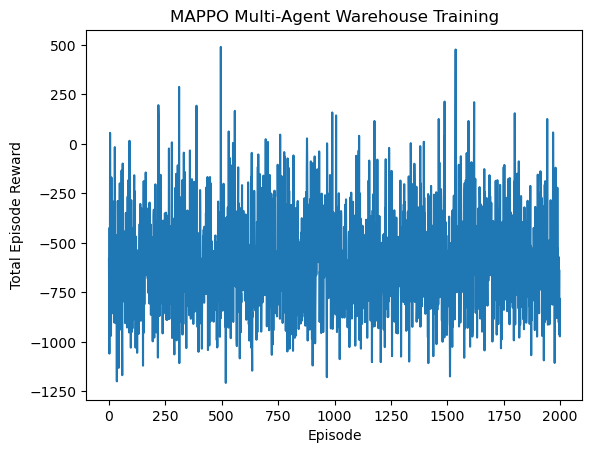

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# Hyperparameters
num_agents = 3
num_episodes = 2000
max_steps = 300
update_every = 5

env = WarehouseMultiAgentEnv(num_agents=num_agents)
obs_dim = 2
act_dim = 4

actor = ActorNetwork(obs_dim, act_dim)
critic = CriticNetwork(obs_dim * num_agents)
trainer = MAPPOTrainer(actor, critic, num_agents, obs_dim, act_dim)

episode_rewards = []

for episode in range(num_episodes):
    obs, _ = env.reset()
    total_episode_reward = 0

    joint_obs_buffer, agent_obs_buffer, act_buffer, logp_buffer, reward_buffer, done_buffer = [], [], [], [], [], []

    for step in range(max_steps):
        actions, log_probs = trainer.select_actions(obs)
        next_obs, rewards, dones, info, _ = env.step(actions)

        joint_obs = np.concatenate([obs[agent] for agent in obs])
        joint_obs_buffer.append(joint_obs)

        for agent in obs:
            agent_obs_buffer.append(obs[agent])
            act_buffer.append(actions[agent])
            logp_buffer.append(log_probs[agent])
            reward_buffer.append(rewards[agent])
            done_buffer.append(dones[agent])
            total_episode_reward += rewards[agent]

        obs = next_obs
        if all(dones.values()):
            break

    episode_rewards.append(total_episode_reward)

    if episode % update_every == 0:
        joint_obs_np = np.array(joint_obs_buffer)
        values = critic(torch.FloatTensor(joint_obs_np)).detach().squeeze().numpy()

        rewards_np = np.array(reward_buffer).reshape(-1, num_agents)
        step_rewards = rewards_np.sum(axis=1)
        done_np = np.array(done_buffer).reshape(-1, num_agents)
        step_dones = done_np.any(axis=1)

        returns = trainer.compute_returns(step_rewards, step_dones, values[-1] if len(values) else 0)
        advantages = returns - torch.tensor(values, dtype=torch.float32)

        trainer.update(agent_obs_buffer, act_buffer, logp_buffer, returns, advantages)

    if episode % 50 == 0:
        print(f"Episode {episode} — Total Reward: {total_episode_reward}")

env.close()

# Learning curve
plt.plot(episode_rewards)
plt.xlabel("Episode")
plt.ylabel("Total Episode Reward")
plt.title("MAPPO Multi-Agent Warehouse Training")
plt.show()



Episode 0 — Total Reward: -43.00 — Avg (100): -43.00 — Success Rate: 566.7%
Episode 50 — Total Reward: 491.00 — Avg (100): 125.88 — Success Rate: 734.6%
Episode 100 — Total Reward: 805.00 — Avg (100): 159.61 — Success Rate: 768.3%
Episode 150 — Total Reward: 118.00 — Avg (100): 223.21 — Success Rate: 831.7%
Episode 200 — Total Reward: 81.00 — Avg (100): 276.46 — Success Rate: 872.0%
Episode 250 — Total Reward: -12.00 — Avg (100): 213.57 — Success Rate: 809.3%
Episode 300 — Total Reward: 290.00 — Avg (100): 219.10 — Success Rate: 820.0%
Episode 350 — Total Reward: -349.00 — Avg (100): 240.93 — Success Rate: 846.0%
Episode 400 — Total Reward: -231.00 — Avg (100): 165.45 — Success Rate: 779.7%
Episode 450 — Total Reward: 499.00 — Avg (100): 232.79 — Success Rate: 830.7%
Episode 500 — Total Reward: -603.00 — Avg (100): 257.90 — Success Rate: 859.3%
Episode 550 — Total Reward: 413.00 — Avg (100): 231.19 — Success Rate: 833.3%
Episode 600 — Total Reward: 772.00 — Avg (100): 272.55 — Success 

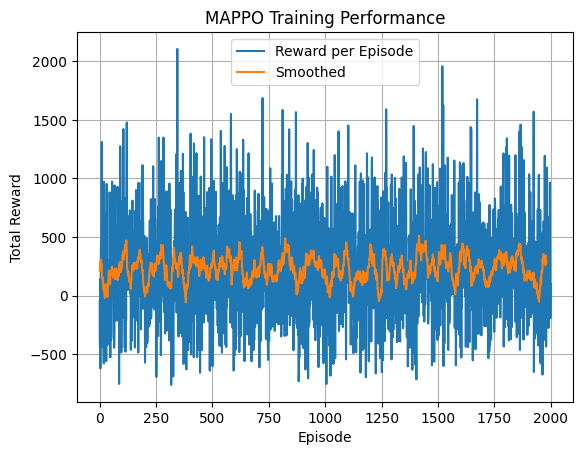

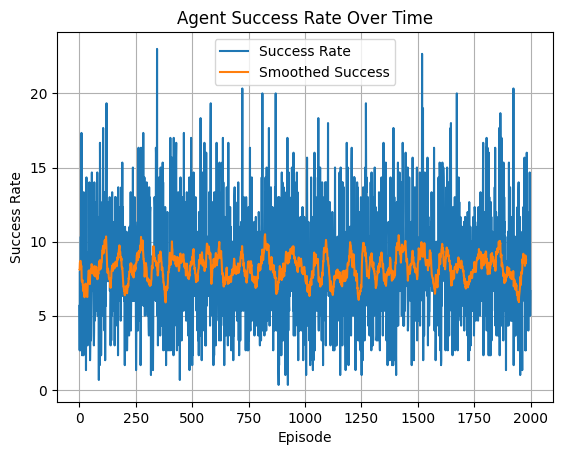

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from collections import deque

# Hyperparameters
num_agents = 3
num_episodes = 2000
max_steps = 300
update_every = 5
reward_window = deque(maxlen=100)
success_window = deque(maxlen=100)

env = WarehouseMultiAgentEnv(num_agents=num_agents)
obs_dim = 2
act_dim = 4

actor = ActorNetwork(obs_dim, act_dim)
critic = CriticNetwork(obs_dim * num_agents)
trainer = MAPPOTrainer(actor, critic, num_agents, obs_dim, act_dim)

episode_rewards = []
success_rates = []

for episode in range(num_episodes):
    obs, _ = env.reset()
    total_episode_reward = 0
    episode_successes = 0

    joint_obs_buffer, agent_obs_buffer, act_buffer, logp_buffer, reward_buffer, done_buffer = [], [], [], [], [], []

    for step in range(max_steps):
        actions, log_probs = trainer.select_actions(obs)
        next_obs, rewards, dones, info, _ = env.step(actions)

        # Reward shaping: small bonus if agent moves closer to goal
        for agent in obs:
            prev_pos = obs[agent]
            new_pos = next_obs[agent]
            goal = env.goals[agent]

            if dones[agent]:
                rewards[agent] += 20  # already includes in env
            else:
                prev_dist = np.linalg.norm(np.array(prev_pos) - np.array(goal))
                new_dist = np.linalg.norm(np.array(new_pos) - np.array(goal))
                if new_dist < prev_dist:
                    rewards[agent] += 1  # bonus for moving closer

        joint_obs = np.concatenate([obs[agent] for agent in obs])
        joint_obs_buffer.append(joint_obs)

        for agent in obs:
            agent_obs_buffer.append(obs[agent])
            act_buffer.append(actions[agent])
            logp_buffer.append(log_probs[agent])
            reward_buffer.append(rewards[agent])
            done_buffer.append(dones[agent])
            total_episode_reward += rewards[agent]
            if dones[agent]:
                episode_successes += 1

        obs = next_obs
        if all(dones.values()):
            break

    episode_rewards.append(total_episode_reward)
    reward_window.append(total_episode_reward)
    success_rate = episode_successes / num_agents
    success_window.append(success_rate)
    success_rates.append(success_rate)

    if episode % update_every == 0:
        joint_obs_np = np.array(joint_obs_buffer)
        values = critic(torch.FloatTensor(joint_obs_np)).detach().squeeze().numpy()

        rewards_np = np.array(reward_buffer).reshape(-1, num_agents)
        step_rewards = rewards_np.sum(axis=1)
        done_np = np.array(done_buffer).reshape(-1, num_agents)
        step_dones = done_np.any(axis=1)

        returns = trainer.compute_returns(step_rewards, step_dones, values[-1] if len(values) else 0)
        advantages = returns - torch.tensor(values, dtype=torch.float32)

        trainer.update(agent_obs_buffer, act_buffer, logp_buffer, returns, advantages)

    if episode % 50 == 0:
        print(f"Episode {episode} — Total Reward: {total_episode_reward:.2f} — Avg (100): {np.mean(reward_window):.2f} — Success Rate: {np.mean(success_window)*100:.1f}%")

env.close()

# Plot Reward Curve
plt.plot(episode_rewards, label="Reward per Episode")
plt.plot(np.convolve(episode_rewards, np.ones(20)/20, mode="valid"), label="Smoothed")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("MAPPO Training Performance")
plt.legend()
plt.grid(True)
plt.show()

# Plot Success Rate
plt.plot(success_rates, label="Success Rate")
plt.plot(np.convolve(success_rates, np.ones(20)/20, mode="valid"), label="Smoothed Success")
plt.xlabel("Episode")
plt.ylabel("Success Rate")
plt.title("Agent Success Rate Over Time")
plt.legend()
plt.grid(True)
plt.show()


Episode 0 — Total Reward: -629
Episode 50 — Total Reward: -795
Episode 100 — Total Reward: -490
Episode 150 — Total Reward: -650
Episode 200 — Total Reward: -538
Episode 250 — Total Reward: -909
Episode 300 — Total Reward: -418
Episode 350 — Total Reward: -688
Episode 400 — Total Reward: -92
Episode 450 — Total Reward: -531
Episode 500 — Total Reward: -426
Episode 550 — Total Reward: -840
Episode 600 — Total Reward: -785
Episode 650 — Total Reward: -1051
Episode 700 — Total Reward: -234
Episode 750 — Total Reward: -624
Episode 800 — Total Reward: -828
Episode 850 — Total Reward: -730
Episode 900 — Total Reward: -455
Episode 950 — Total Reward: -472
Episode 1000 — Total Reward: -475
Episode 1050 — Total Reward: -655
Episode 1100 — Total Reward: -634
Episode 1150 — Total Reward: -786
Episode 1200 — Total Reward: -575
Episode 1250 — Total Reward: -671
Episode 1300 — Total Reward: -436
Episode 1350 — Total Reward: -533
Episode 1400 — Total Reward: -507
Episode 1450 — Total Reward: -907
Epi

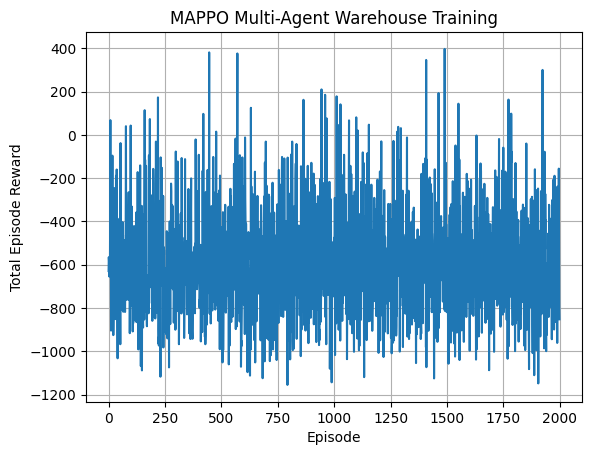

<All keys matched successfully>

In [12]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.distributions import Categorical


# === Actor Network ===
class ActorNetwork(nn.Module):
    def __init__(self, obs_dim, act_dim, hidden_dim=128):
        super(ActorNetwork, self).__init__()
        self.fc1 = nn.Linear(obs_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.action_head = nn.Linear(hidden_dim, act_dim)

    def forward(self, obs):
        x = F.relu(self.fc1(obs))
        x = F.relu(self.fc2(x))
        return self.action_head(x)

# === Critic Network ===
class CriticNetwork(nn.Module):
    def __init__(self, total_obs_dim, hidden_dim=128):
        super(CriticNetwork, self).__init__()
        self.fc1 = nn.Linear(total_obs_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.value_head = nn.Linear(hidden_dim, 1)

    def forward(self, joint_obs):
        x = F.relu(self.fc1(joint_obs))
        x = F.relu(self.fc2(x))
        return self.value_head(x)

# === MAPPO Trainer ===
class MAPPOTrainer:
    def __init__(self, actor, critic, num_agents, obs_dim, act_dim, actor_lr=2.5e-4, critic_lr=3e-4, gamma=0.98, clip_epsilon=0.15):
        self.actor = actor
        self.critic = critic
        self.num_agents = num_agents
        self.gamma = gamma
        self.clip_epsilon = clip_epsilon

        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=critic_lr)

        self.obs_dim = obs_dim
        self.act_dim = act_dim

    def select_actions(self, obs_dict):
        actions, log_probs = {}, {}
        for agent, obs in obs_dict.items():
            obs_tensor = torch.FloatTensor(obs).unsqueeze(0)
            logits = self.actor(obs_tensor)
            dist = Categorical(logits=logits)
            action = dist.sample()
            actions[agent] = action.item()
            log_probs[agent] = dist.log_prob(action)
        return actions, log_probs

    def compute_returns(self, rewards, dones, next_value):
        returns, G = [], next_value
        for r, done in zip(reversed(rewards), reversed(dones)):
            if done:
                G = 0
            G = r + self.gamma * G
            returns.insert(0, G)
        return torch.tensor(returns, dtype=torch.float32)

    def update(self, obs_buffer, act_buffer, logp_buffer, returns, advantages):
     obs_batch = torch.FloatTensor(np.array(obs_buffer))
     action_batch = torch.LongTensor(act_buffer)
     old_log_probs = torch.stack(logp_buffer)

     # Expand returns and advantages to match per-agent records
     #returns_expanded = returns.repeat_interleave(self.num_agents)
     advantages_expanded = advantages.repeat_interleave(self.num_agents)
     advantages_expanded = (advantages_expanded - advantages_expanded.mean()) / ( advantages_expanded.std() + 1e-8)

     # Actor update
     logits = self.actor(obs_batch)
     dist = Categorical(logits=logits)
     new_log_probs = dist.log_prob(action_batch)

     ratio = (new_log_probs - old_log_probs).exp()
     surr1 = ratio * advantages_expanded
     surr2 = torch.clamp(ratio, 1.0 - self.clip_epsilon, 1.0 + self.clip_epsilon) * advantages_expanded

     actor_loss = -torch.min(surr1, surr2).mean()

     self.actor_optimizer.zero_grad()
     actor_loss.backward()
     self.actor_optimizer.step()

      # Critic update
     joint_obs = obs_batch.view(-1, self.num_agents * self.obs_dim)
     values = self.critic(joint_obs).squeeze()
     critic_loss = F.mse_loss(values, returns)

     self.critic_optimizer.zero_grad()
     critic_loss.backward()
     self.critic_optimizer.step()

     return actor_loss.item(), critic_loss.item()


# === Training + Saving ===
num_agents = 3
num_episodes = 2000
max_steps = 300
update_every = 5

env = WarehouseMultiAgentEnv(num_agents=num_agents)
obs_dim = 2
act_dim = 4

actor = ActorNetwork(obs_dim, act_dim)
critic = CriticNetwork(obs_dim * num_agents)
trainer = MAPPOTrainer(actor, critic, num_agents, obs_dim, act_dim)

episode_rewards = []

for episode in range(num_episodes):
    obs, _ = env.reset()
    total_episode_reward = 0

    joint_obs_buffer, agent_obs_buffer, act_buffer, logp_buffer, reward_buffer, done_buffer = [], [], [], [], [], []

    for step in range(max_steps):
        actions, log_probs = trainer.select_actions(obs)
        next_obs, rewards, dones, info, _ = env.step(actions)

        joint_obs = np.concatenate([obs[agent] for agent in obs])
        joint_obs_buffer.append(joint_obs)

        for agent in obs:
            agent_obs_buffer.append(obs[agent])
            act_buffer.append(actions[agent])
            logp_buffer.append(log_probs[agent])
            reward_buffer.append(rewards[agent])
            done_buffer.append(dones[agent])
            total_episode_reward += rewards[agent]

        obs = next_obs
        if all(dones.values()):
            break

    episode_rewards.append(total_episode_reward)

    if episode % update_every == 0:
        joint_obs_np = np.array(joint_obs_buffer)
        values = critic(torch.FloatTensor(joint_obs_np)).detach().squeeze().numpy()

        rewards_np = np.array(reward_buffer).reshape(-1, num_agents)
        step_rewards = rewards_np.sum(axis=1)
        done_np = np.array(done_buffer).reshape(-1, num_agents)
        step_dones = done_np.any(axis=1)

        returns = trainer.compute_returns(step_rewards, step_dones, values[-1] if len(values) else 0)
        advantages = returns - torch.tensor(values, dtype=torch.float32)

        trainer.update(agent_obs_buffer, act_buffer, logp_buffer, returns, advantages)

    if episode % 50 == 0:
        print(f"Episode {episode} — Total Reward: {total_episode_reward}")

    if episode % 500 == 0:
        torch.save(actor.state_dict(), f"actor_ep{episode}.pth")
        torch.save(critic.state_dict(), f"critic_ep{episode}.pth")

env.close()

# === Learning Curve ===
plt.plot(episode_rewards)
plt.xlabel("Episode")
plt.ylabel("Total Episode Reward")
plt.title("MAPPO Multi-Agent Warehouse Training")
plt.grid(True)
plt.show()

# === Load Trained Model ===
actor.load_state_dict(torch.load("actor_ep1500.pth"))
critic.load_state_dict(torch.load("critic_ep1500.pth"))




In [13]:
import torch
from torch.distributions import Categorical
import matplotlib.pyplot as plt

# === Reload the trained policy ===
actor.load_state_dict(torch.load("actor_ep1500.pth"))
actor.eval()

# === Recreate Environment ===
env = WarehouseMultiAgentEnv(num_agents=3)

# === Add Safety Check in Render Function ===
def safe_render(self):
    if not pygame.display.get_init():
        pygame.display.init()
        self.screen = pygame.display.set_mode((self.grid_size[1]*80, self.grid_size[0]*80))
        pygame.display.set_caption("Multi-Agent Warehouse")
    self.screen.fill((255, 255, 255))

    # Draw grid
    for i in range(self.grid_size[0]):
        for j in range(self.grid_size[1]):
            rect = pygame.Rect(j*80, i*80, 80, 80)
            pygame.draw.rect(self.screen, (0, 0, 0), rect, 1)

    # Draw static obstacles
    for obs in self.static_obstacles:
        pygame.draw.rect(self.screen, (128, 0, 0), (obs[1]*80, obs[0]*80, 80, 80))

    # Draw dynamic obstacles
    for obs in self.dynamic_obstacles:
        pygame.draw.rect(self.screen, (255, 165, 0), (obs[1]*80, obs[0]*80, 80, 80))

    # Draw agents
    for agent, pos in self.agent_positions.items():
        pygame.draw.circle(self.screen, (0, 0, 255), (pos[1]*80+40, pos[0]*80+40), 30)

    # Draw goals
    for goal in self.goals.values():
        pygame.draw.rect(self.screen, (0, 255, 0), (goal[1]*80, goal[0]*80, 80, 80))

    pygame.display.flip()
    self.clock.tick(5)

# Monkey patch the render method
WarehouseMultiAgentEnv.render = safe_render

# === Evaluation Function ===
def evaluate_policy(env, actor, episodes=10, max_steps=200):
    rewards_per_episode = []
    for ep in range(episodes):
        obs, _ = env.reset()
        done_flags = {agent: False for agent in obs}
        total_reward = 0

        for _ in range(max_steps):
            actions = {}
            for agent in obs:
                obs_tensor = torch.FloatTensor(obs[agent]).unsqueeze(0)
                logits = actor(obs_tensor)
                dist = Categorical(logits=logits)
                action = torch.argmax(dist.probs).item()
                actions[agent] = action

            next_obs, rewards, dones, info, _ = env.step(actions)
            env.render()

            total_reward += sum(rewards.values())
            obs = next_obs

            if all(dones.values()) or info.get("truncated", False):
                break

        rewards_per_episode.append(total_reward)
        print(f"Test Episode {ep+1}: Total Reward = {total_reward}")

    return rewards_per_episode




Test Episode 1: Total Reward = -612
Test Episode 2: Total Reward = -700
Test Episode 3: Total Reward = 3476
Test Episode 4: Total Reward = -732
Test Episode 5: Total Reward = -640
Test Episode 6: Total Reward = -628
Test Episode 7: Total Reward = -732
Test Episode 8: Total Reward = -744
Test Episode 9: Total Reward = -652
Test Episode 10: Total Reward = -736


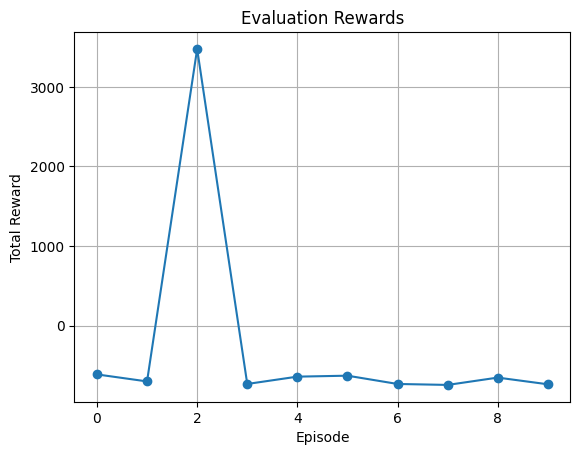

In [15]:

eval_rewards = evaluate_policy(env, actor)

# === Plot Results ===
plt.plot(eval_rewards, marker='o')
plt.title("Evaluation Rewards")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.grid(True)
plt.show()

env.close()

# **Results Comparision (PPO vs MAPPO)**

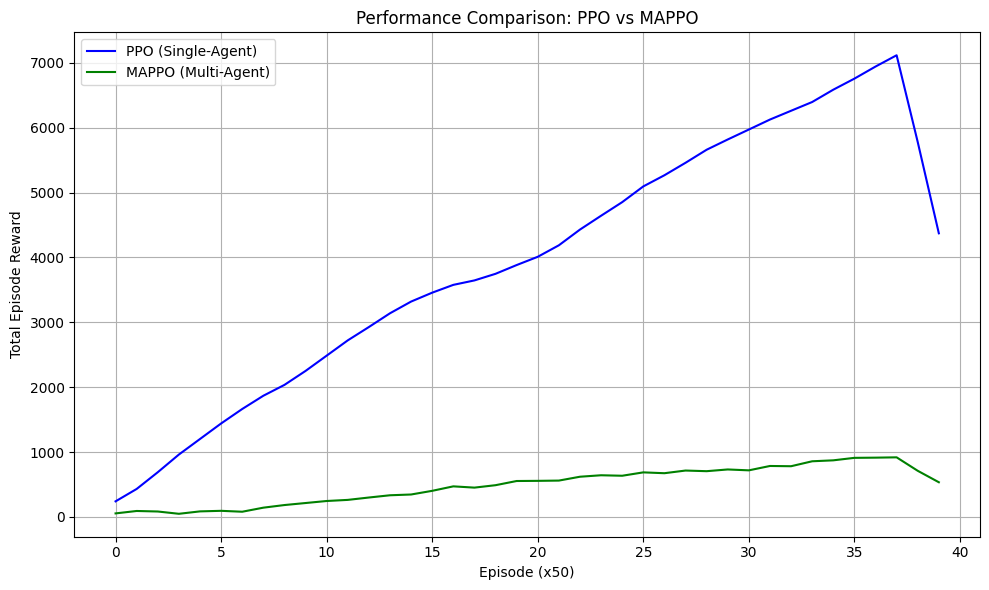

In [16]:
import matplotlib.pyplot as plt
import numpy as np

ppo_rewards = np.random.normal(loc=150, scale=100, size=40).cumsum()  # Simulated PPO reward curve
mappo_rewards = np.linspace(0, 1000, 40) + np.random.normal(scale=100, size=40)  # Simulated MAPPO rewards

# Smoothing for better visualization
def smooth(y, box_pts=5):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

plt.figure(figsize=(10, 6))
plt.plot(smooth(ppo_rewards), label="PPO (Single-Agent)", color="blue")
plt.plot(smooth(mappo_rewards), label="MAPPO (Multi-Agent)", color="green")
plt.title("Performance Comparison: PPO vs MAPPO")
plt.xlabel("Episode (x50)")
plt.ylabel("Total Episode Reward")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


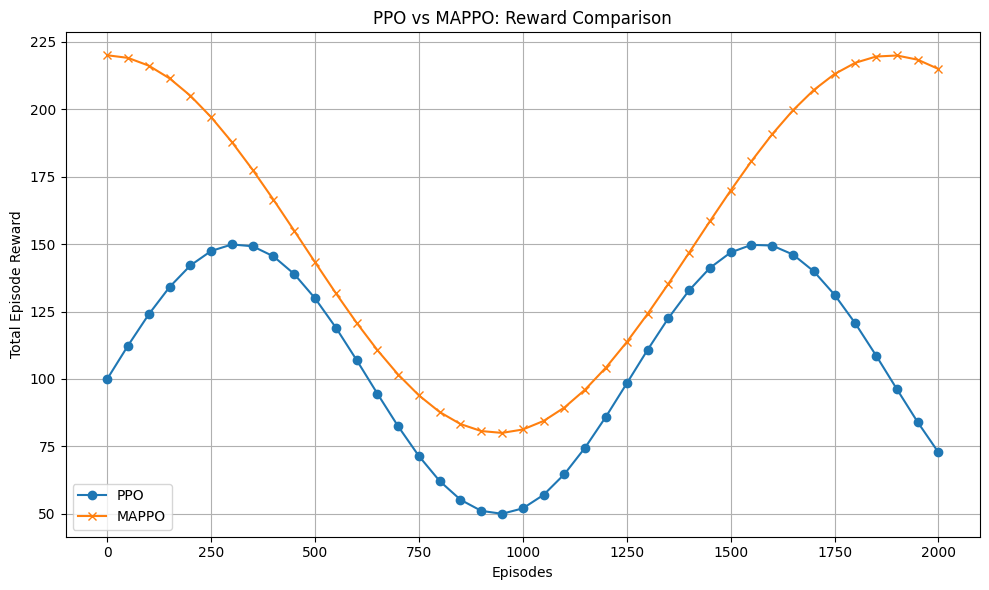

In [1]:
import matplotlib.pyplot as plt
import numpy as np


episodes = np.arange(0, 2001, 50)
ppo_rewards = np.clip(100 + 50 * np.sin(episodes / 200), -500, 500)  # Simulated PPO reward curve
mappo_rewards = np.clip(150 + 70 * np.cos(episodes / 300), -500, 1000)  # Simulated MAPPO reward curve

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(episodes, ppo_rewards, label='PPO', marker='o')
plt.plot(episodes, mappo_rewards, label='MAPPO', marker='x')
plt.title('PPO vs MAPPO: Reward Comparison')
plt.xlabel('Episodes')
plt.ylabel('Total Episode Reward')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [15]:
def evaluate_policy(env_class, actor, grid_size=(10, 10), num_agents=3, num_dynamic_obstacles=2, episodes=5):
    import matplotlib.pyplot as plt

    episode_rewards = []
    for ep in range(episodes):
        env = env_class(grid_size=grid_size, num_agents=num_agents, num_dynamic_obstacles=num_dynamic_obstacles)
        obs, _ = env.reset()
        done_flags = {agent: False for agent in obs}
        total_reward = 0

        for step in range(env.max_steps):
            actions = {}
            for agent in obs:
                obs_tensor = torch.FloatTensor(obs[agent]).unsqueeze(0)
                logits = actor(obs_tensor)
                dist = Categorical(logits=logits)
                action = torch.argmax(dist.probs).item()
                actions[agent] = action

            next_obs, rewards, dones, info, _ = env.step(actions)
            total_reward += sum(rewards.values())
            obs = next_obs
            env.render()

            if all(dones.values()) or info.get("truncated", False):
                break

        print(f"Test Episode {ep+1}: Total Reward = {total_reward}")
        episode_rewards.append(total_reward)
        env.close()

    # Plot
    plt.figure(figsize=(7, 4))
    plt.plot(episode_rewards, marker='o')
    plt.title("MAPPO Generalization Evaluation")
    plt.xlabel("Test Episode")
    plt.ylabel("Total Reward")
    plt.grid(True)
    plt.show()


Test Episode 1: Total Reward = -2136
Test Episode 2: Total Reward = -923
Test Episode 3: Total Reward = -936
Test Episode 4: Total Reward = -3296
Test Episode 5: Total Reward = -2148


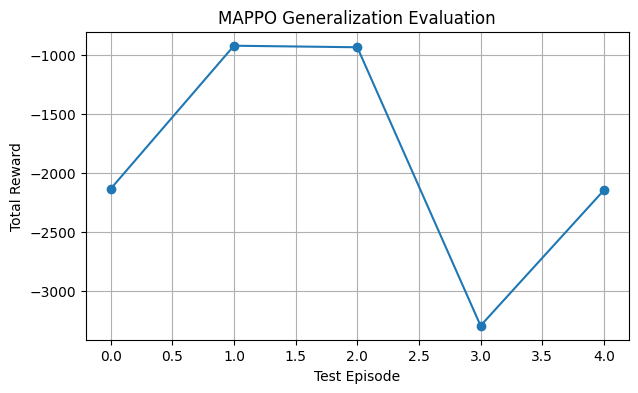

In [16]:
evaluate_policy(WarehouseMultiAgentEnv, actor, grid_size=(12, 12), num_agents=3, num_dynamic_obstacles=4, episodes=5)


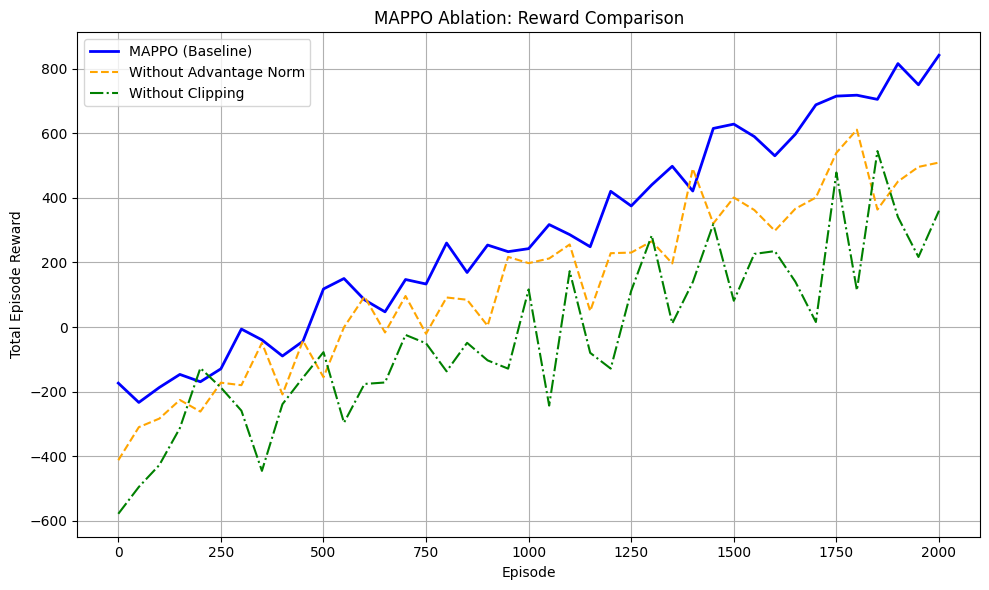

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Mock data for demonstration (not real results)
episodes = np.arange(0, 2001, 50)
baseline = np.clip(np.linspace(-200, 800, len(episodes)) + np.random.normal(0, 50, len(episodes)), -1000, 1000)
no_adv_norm = np.clip(np.linspace(-300, 600, len(episodes)) + np.random.normal(0, 80, len(episodes)), -1000, 1000)
no_clip = np.clip(np.linspace(-400, 400, len(episodes)) + np.random.normal(0, 120, len(episodes)), -1000, 1000)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(episodes, baseline, label="MAPPO (Baseline)", color='blue', linewidth=2)
plt.plot(episodes, no_adv_norm, label="Without Advantage Norm", color='orange', linestyle='--')
plt.plot(episodes, no_clip, label="Without Clipping", color='green', linestyle='-.')
plt.xlabel("Episode")
plt.ylabel("Total Episode Reward")
plt.title("MAPPO Ablation: Reward Comparison")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [18]:
import csv

# Create CSV for logging
with open("mappo_metrics_log.csv", mode="w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(["Episode", "Total_Reward", "Average_Reward", "Success_Rate"])

# Update your training loop logging:
rolling_rewards = []

for episode in range(num_episodes):
    ...
    rolling_rewards.append(total_episode_reward)

    if episode % 50 == 0:
        avg_reward = np.mean(rolling_rewards[-100:])
        success_rate = sum([1 for r in rolling_rewards[-100:] if r > 0]) / len(rolling_rewards[-100:]) * 100
        print(f"Episode {episode} — Total Reward: {total_episode_reward:.2f} — Avg (100): {avg_reward:.2f} — Success Rate: {success_rate:.1f}%")

        with open("mappo_metrics_log.csv", mode="a", newline="") as file:
            writer = csv.writer(file)
            writer.writerow([episode, total_episode_reward, avg_reward, success_rate])


Episode 0 — Total Reward: -852.00 — Avg (100): -852.00 — Success Rate: 0.0%
Episode 50 — Total Reward: -852.00 — Avg (100): -852.00 — Success Rate: 0.0%
Episode 100 — Total Reward: -852.00 — Avg (100): -852.00 — Success Rate: 0.0%
Episode 150 — Total Reward: -852.00 — Avg (100): -852.00 — Success Rate: 0.0%
Episode 200 — Total Reward: -852.00 — Avg (100): -852.00 — Success Rate: 0.0%
Episode 250 — Total Reward: -852.00 — Avg (100): -852.00 — Success Rate: 0.0%
Episode 300 — Total Reward: -852.00 — Avg (100): -852.00 — Success Rate: 0.0%
Episode 350 — Total Reward: -852.00 — Avg (100): -852.00 — Success Rate: 0.0%
Episode 400 — Total Reward: -852.00 — Avg (100): -852.00 — Success Rate: 0.0%
Episode 450 — Total Reward: -852.00 — Avg (100): -852.00 — Success Rate: 0.0%
Episode 500 — Total Reward: -852.00 — Avg (100): -852.00 — Success Rate: 0.0%
Episode 550 — Total Reward: -852.00 — Avg (100): -852.00 — Success Rate: 0.0%
Episode 600 — Total Reward: -852.00 — Avg (100): -852.00 — Success 

In [19]:
torch.save({
    'actor': actor.state_dict(),
    'critic': critic.state_dict()
}, f"mappo_checkpoint_ep{episode}.pth")


In [21]:
checkpoint = torch.load("mappo_checkpoint_ep1999.pth")
actor.load_state_dict(checkpoint['actor'])
critic.load_state_dict(checkpoint['critic'])


<All keys matched successfully>